In [9]:
# Test to show receive and re-transmit of internal dds signal
# verifies operation of readRx() and writeTx()
from pluto.pluto_sdr import PlutoSdr
sdr = PlutoSdr()
%matplotlib inline

In [10]:
# set up tx and rx on same channel and physically connect via the loop-back cable
sdr.rx_lo_freq = 430                  # frequency units are in MHz
sdr.tx_lo_freq = 430
sdr.tx_gain = -30

In [17]:
# turn on a test signal from the internal DDS
sdr.sampling_frequency = 10
sdr.ddsFrequ(0.5)                # single tone
sdr.ddsAmplitude(-10)            # amplitude in dB wrt full scale
sdr.tx_state = sdr.TX_DDS

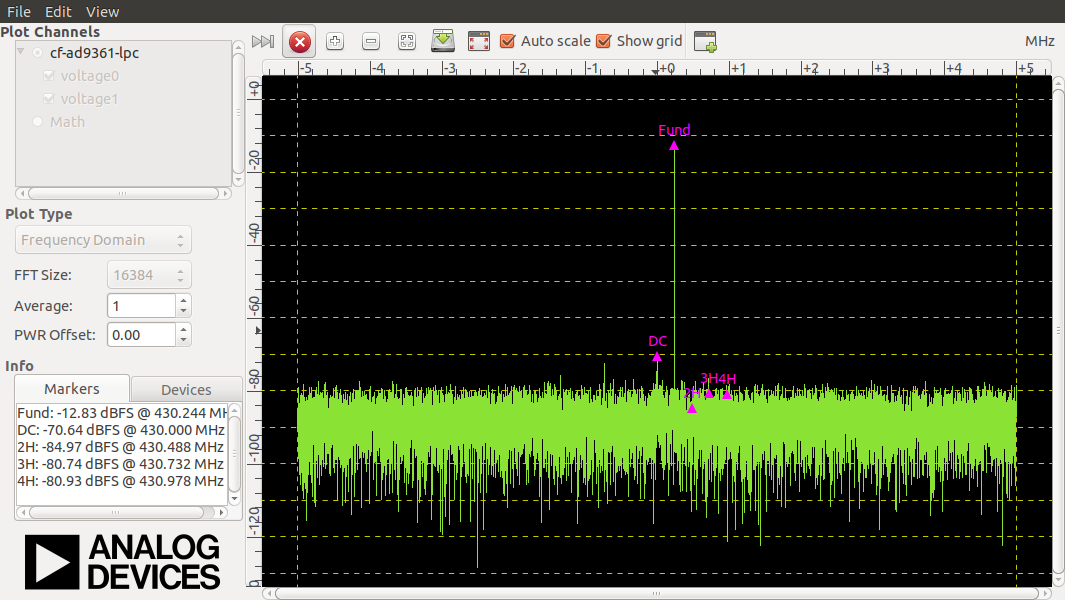

In [13]:
# show pluto output as seen via iio Scope
from IPython.display import Image
display(Image('dds_capture.png', width=800, height=800))

In [18]:
# collect data from rx
dds_data = sdr.readRx(0x4000, raw=False)

Text(0.5,1,'DDS signal')

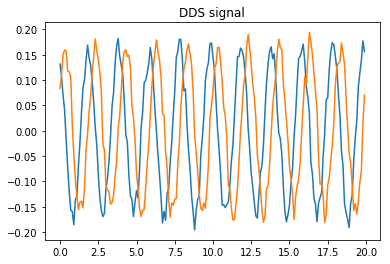

In [19]:
# data visualisation using matplotlib
# create the time axis
time = arange(len(dds_data))/sdr.sampling_frequency
zoom = slice(200)               # slice operator provides a sub-section of a data array
plot(time[zoom], dds_data.real[zoom], time[zoom], dds_data.imag[zoom])
plt.title('DDS signal')

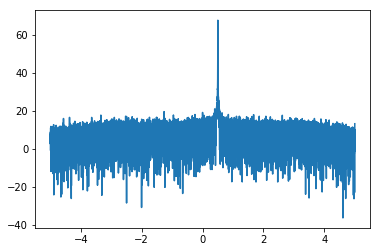

In [20]:
# frequency domain visualisation
from numpy.fft import fft, fftfreq, fftshift
fr_x = fftshift(fftfreq(len(dds_data), 1/sdr.sampling_frequency))
F_x = fftshift(fft(dds_data))
plot(fr_x, 20*np.log10(np.abs(F_x)))

Text(0.5,1,'no signal')

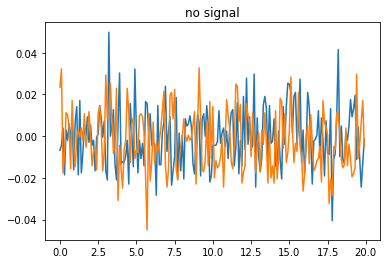

In [22]:
# turn DDS off then re-transmit using captured data
sdr.tx_state = sdr.TX_OFF
off_data = sdr.readRx(0x4000, raw=False)
plt.plot(time[zoom], off_data.real[zoom], time[zoom], off_data.imag[zoom])
plt.title('no signal')

Text(0.5,1,'recorded signal')

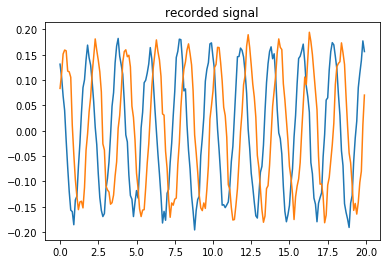

In [24]:
# re-transmit the recorded data from the dds
sdr.tx_state = sdr.TX_DMA
sdr.writeTx(dds_data)
tx_data = sdr.readRx(0x4000, raw=False)
plot(time[zoom], dds_data.real[zoom], time[zoom], dds_data.imag[zoom])
plt.title('recorded signal')

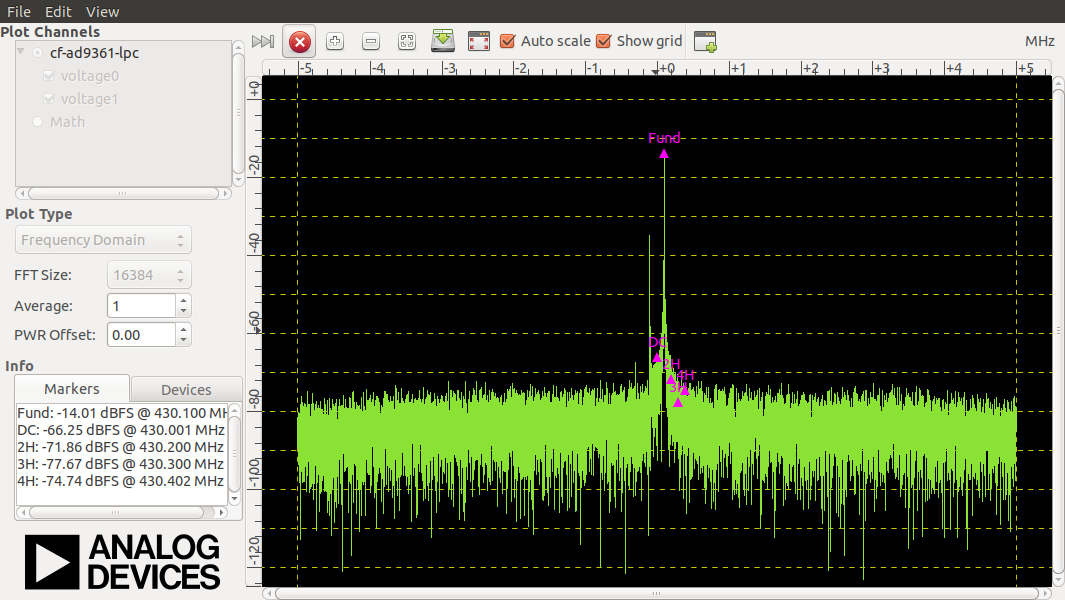

In [25]:
display(Image('rx_recording_capture.png', width=800, height=800))

In [26]:
# to see a clean signal from data, create one that fits exactly into the sample array
def fitCycles(cycles, length, complex=False):
    xx = np.arange(length)
    arg = 2*np.pi*xx*cycles/length
    if complex:
        return np.cos(arg) + 1j*np.sin(arg)
    else:
        return np.sin(arg)


iq = fitCycles(400, 0x4000, True)*0.5     # scale to 0.5 to prevent overload ogf DAC


Text(0.5,1,'ideal signal')

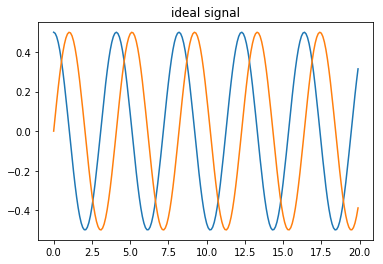

In [27]:
plot(time[zoom], iq.real[zoom], time[zoom], iq.imag[zoom])
plt.title('ideal signal')

Text(0.5,1,'ideal recorded signal')

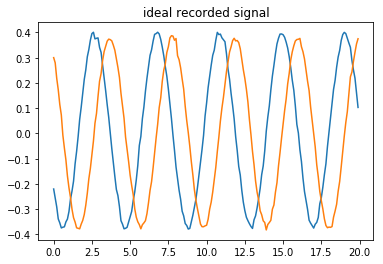

In [28]:
#sdr.writeTx(0)
sdr.writeTx(iq)
ideal_data = sdr.readRx(0x4000, raw=False)
plot(time[zoom], ideal_data.real[zoom], time[zoom], ideal_data.imag[zoom])
plt.title('ideal recorded signal')

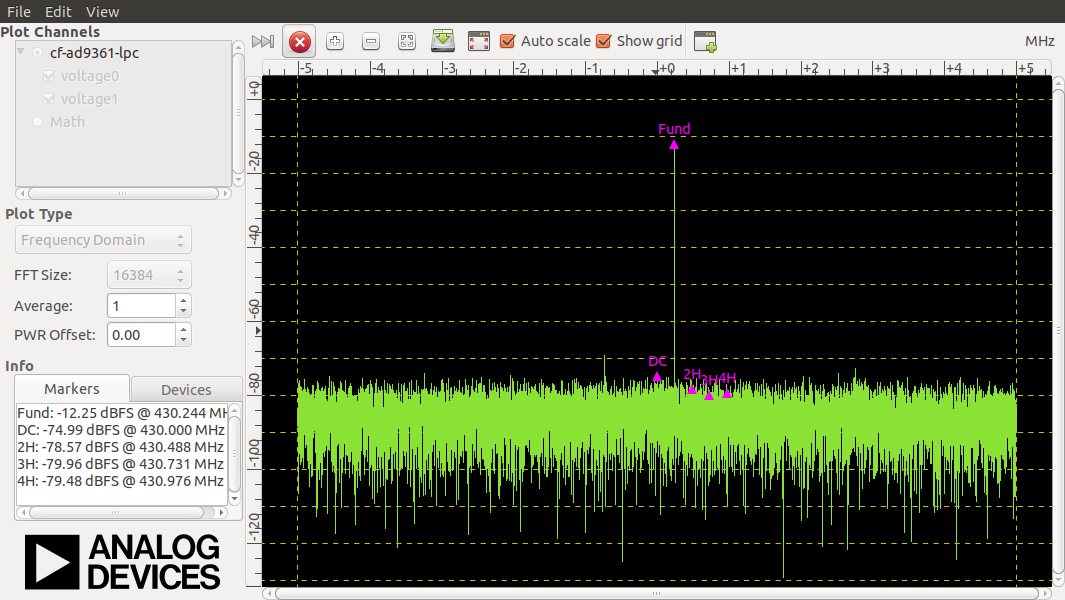

In [29]:
display(Image('ideal_recording_capture.png', width=800, height=800))